In [1]:
# Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Importing the dataset
dataset = pd.read_csv('/Users/monipeni/Documents/Deep_Learning_A_Z/Volume 2 - Unsupervised Deep Learning/Part 4 - Self Organizing Maps (SOM)/Credit_Card_Applications.csv')

In [3]:
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [4]:
X = dataset.iloc[:, :-1].values # we want all the lines. We want all the columns except the last one
y = dataset.iloc[:, -1].values # we only want the last column

In [5]:
# Feature Scaling

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)) # we want values between 0 and 1, that´s normalization
X = sc.fit_transform(X)

In [6]:
# Training the SOM:

from minisom import MiniSom

# Create SOM object
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5) 
    # the first arguments are the dimensions of the map, as we don´t have many observations, not too much customers
    # in our fraud detection dataset , so we choose 10 by 10 grid.
    # input_len correspond to the number of features we have in our X dataset, because we are training
    # the SOM object on X. X contains 14 attributes and the Customer ID. We don´t need to consider the customer ID
    # because don´t have significance on the patterns, but we are gonna keep it because we want to identify the
    # potential cheaters and for this we will need the Customer ID. So input_len is 14 attributes + CustomerID = 15
    # we mantain the default values for sigma (the radius of the different neighborhoods in the grid) and 
    # learning_rate is the hyper-parameter that decides by how much the weights are updated during each iteration,
    # so the lower is the learning rate, the longer the self-organizing map will take time to be built.

# we need to initialize randomly the values of the weight vectors to small numbers close to 0, and then we can 
# train the whole algorithm
som.random_weights_init(X) # we introduce (X) that is the data that we want to be trained

# Train the self-organizing map object on X
som.train_random(data = X, num_iteration = 100) # 100 it´s the number of iterations we want to repeat steps 4 to 9

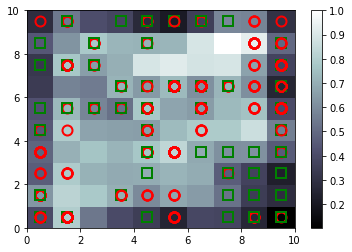

In [7]:
# Visualizing the results

from pylab import bone, pcolor, colorbar, plot, show
bone() # this is the window that will contain the map
pcolor(som.distance_map().T) # T is to take the transpose of the matrix returned by the distance map method
colorbar() # to know what these colors correspond to
markers = ['o', 's'] # we want a circle and a square
colors = ['r', 'g'] # we want to color the markers, in red and green
for i, x in enumerate(X): # i is going to be the different values of all the indexes (0,1,2,3... till 689)
                          # x is going to be different vectors of costumers at the different iterations
                          # enumerate(X), X that contain all our costumers
    w = som.winner(x) # this will get us the winning node of the customer x
    plot(w[0] + 0.5, # this is the x coordinate of the winning node 
         w[1] + 0.5, # this is the y coordinate (we add 0.5 to put the marker in the center of the square)
         markers[y[i]], # i is the index of the customer, y the value of the dependent variable for that customer
                        # that is 0 if the customer didn´t get approval and 1 if get approval
                        # if the customer got approval y i will be equal to 1, so markers are equals to 1 and 
                        # corresponds to square (markers=['o','s']) 0 is 'o' 1 is 's'
         markeredgecolor = colors[y[i]], # we are only color the edge of the marker
         markerfacecolor = 'None', # we don´t colour the inside color
         markersize = 10, # because we want to see the markers
         markeredgewidth = 2) 
show()

In [10]:
# Finding the frauds
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(9,9)], mappings[(7,9)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [11]:
# Part 2 - Going from Unsupervised to Supervised Deep Learning

# Creating the matrix of features

customers = dataset.iloc[:, 1:].values # is same as X before, but we accept all the columns except the first one
                                       # we don´t want the Customers ID for the ANN

In [12]:
# Creating the dependent variable

is_fraud = np.zeros(len(dataset)) # we create a vector of 0, like nobody is a cheater, len(dataset) is all the data
for i in range(len(dataset)): # we create a loop to look in all the data to check if the customer is in the list
    if dataset.iloc[i,0] in frauds:    # of frauds that we made before [i,0], the i correspond to the i´s line of 
        is_fraud[i] = 1                # the dataset (each costumer) and 0 because the first column is Costumer ID

In [13]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

In [14]:
# let's make the ANN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [15]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15)) # 15 features

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(customers, is_fraud, batch_size = 1, epochs = 2) # 2 epochs because our dataset is small

Epoch 1/2
690/690 [==============================] - 3s 4ms/step - loss: 0.4237 - accuracy: 0.9942
Epoch 2/2
690/690 [==============================] - 2s 3ms/step - loss: 0.0967 - accuracy: 0.9942


In [16]:
# Predicting the probabilities of frauds
y_pred = classifier.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1) #axis 1 because we need horitzontal concat
        # we need all the rows and only the column of the Customer ID that is 0, so would be [:,0], but
        # y_pred is a 2D array, if we want to concatenate we have to make this 2D too and the trick is to add a 1
        # dataset.iloc[:, 0:1] adding this 1, is the same column of Customer ID but in 2 dimensions array
        # and we add .values to make a numpay array
        # with this line we get a 2D array containing 2 columns, the first column containing the Customer ID and
        # the second column of predicted probabilities.
y_pred = y_pred[y_pred[:, 1].argsort()] # we want to sort only the column of probability, the number 1. We will
        # obtain the column 1 in order from lower to higher probability

In [17]:
y_pred

array([[1.56214230e+07, 2.10821629e-03],
       [1.57997850e+07, 3.11464071e-03],
       [1.56548590e+07, 6.36404753e-03],
       ...,
       [1.55933450e+07, 1.39790446e-01],
       [1.58137180e+07, 2.47581542e-01],
       [1.57901130e+07, 2.63559163e-01]])

In [18]:
Predictions = pd.DataFrame(y_pred)
Predictions.head()

,0,1
0,15621423.0,0.002108
1,15799785.0,0.003115
2,15654859.0,0.006364
3,15600975.0,0.007927
4,15585855.0,0.008239


In [19]:
Predictions.shape

(690, 2)

In [20]:
Predictions.tail()

,0,1
685,15712877.0,0.133202
686,15647191.0,0.137833
687,15593345.0,0.139790
688,15813718.0,0.247582
689,15790113.0,0.263559


We get a ranking sorted from the lower to the higher probability of fraud of the customers. The fraud department can use this ranking for investigate the fraud starting with the highest probabilities of fraud.